## Predicting Rossmann store sales using Spark framework

### Initialize the spark

In [1]:

import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

df = spark.sql('''select 'spark' as hello ''')

df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



# Introduction
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

This dataset is taken from a kaggle competition
The dataset contains historical sales data for 1,115 Rossmann stores.

train.csv - historical data including Sales
store.csv - supplemental information about the stores

As part of this exercise, we build a model to predict sales in various stores and use spark framework to explore and build predictive model.

# Importing Data

In [2]:
retail_df = spark.read.csv('C:/Users/USER/Desktop/PySpark/Rossman Stores/train.csv',inferSchema=True,header=True)

In [3]:
retail_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)



From kaggle site, the column definitions are as follows

- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- Promo - indicates whether a store is running a promo on that day

# Exploring the data

In [4]:
retail_df.cache()

DataFrame[Store: int, DayOfWeek: int, Date: timestamp, Sales: int, Customers: int, Open: int, Promo: int, StateHoliday: string, SchoolHoliday: int]

In [5]:
retail_df.show( 5 )

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|
|    2|        5|2015-07-31 00:00:00| 6064|      625|   1|    1|           0|            1|
|    3|        5|2015-07-31 00:00:00| 8314|      821|   1|    1|           0|            1|
|    4|        5|2015-07-31 00:00:00|13995|     1498|   1|    1|           0|            1|
|    5|        5|2015-07-31 00:00:00| 4822|      559|   1|    1|           0|            1|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



In [7]:
retail_df.count()

1017209

In [10]:
retail_df.columns

['Store',
 'DayOfWeek',
 'Date',
 'Sales',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday']

In [13]:
#Selecting few columns from a dataframe
sales_custs_df = retail_df.select( "Store", "Sales", "Customers" )

In [14]:
sales_custs_df.show( 5 )

+-----+-----+---------+
|Store|Sales|Customers|
+-----+-----+---------+
|    1| 5263|      555|
|    2| 6064|      625|
|    3| 8314|      821|
|    4|13995|     1498|
|    5| 4822|      559|
+-----+-----+---------+
only showing top 5 rows



In [15]:
#Filtering records based on a condition
retails_open_df = retail_df.where( retail_df.Open > 0  )

In [16]:
retails_open_df.show( 5 )

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|
|    2|        5|2015-07-31 00:00:00| 6064|      625|   1|    1|           0|            1|
|    3|        5|2015-07-31 00:00:00| 8314|      821|   1|    1|           0|            1|
|    4|        5|2015-07-31 00:00:00|13995|     1498|   1|    1|           0|            1|
|    5|        5|2015-07-31 00:00:00| 4822|      559|   1|    1|           0|            1|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+
only showing top 5 rows



In [17]:
#How many stores remained "Open" on days when it was both school and state holiday?
holidays_df = retail_df.where( ( retail_df.StateHoliday == 1 ) & ( retail_df.SchoolHoliday == 1 ) )

In [18]:
holidays_df.where( holidays_df.Open == 0 ).show( 1 )

+-----+---------+----+-----+---------+----+-----+------------+-------------+
|Store|DayOfWeek|Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|
+-----+---------+----+-----+---------+----+-----+------------+-------------+
+-----+---------+----+-----+---------+----+-----+------------+-------------+



None of those days any store was opened?

In [22]:
#How many stores?
store_ids = retail_df.select( retail_df.Store ).distinct()

store_ids.count()

1115

In [23]:
#Which weekday have maximum number of promos running?
weekday_promos = retail_df.stat.crosstab( "DayOfWeek" , "Promo" )
weekday_promos.show( 10 )

+---------------+------+-----+
|DayOfWeek_Promo|     0|    1|
+---------------+------+-----+
|              5| 68265|77580|
|              1| 66970|77760|
|              6|144730|    0|
|              2| 68084|77580|
|              7|144730|    0|
|              3| 68085|77580|
|              4| 68265|77580|
+---------------+------+-----+



In [24]:
#Renaming the columns
weekday_promos = weekday_promos.withColumnRenamed( "DayOfWeek_Promo", "DayOfWeek" )  \
                             .withColumnRenamed( "0", "NoPromo" )                  \
                             .withColumnRenamed( "1","Promo" )

In [25]:
weekday_promos.show(5)

+---------+-------+-----+
|DayOfWeek|NoPromo|Promo|
+---------+-------+-----+
|        5|  68265|77580|
|        1|  66970|77760|
|        6| 144730|    0|
|        2|  68084|77580|
|        7| 144730|    0|
+---------+-------+-----+
only showing top 5 rows



In [27]:
#Sorting dataframe by column in ascending and descending order
weekday_promos.sort( "Promo" ).show()

+---------+-------+-----+
|DayOfWeek|NoPromo|Promo|
+---------+-------+-----+
|        7| 144730|    0|
|        6| 144730|    0|
|        3|  68085|77580|
|        2|  68084|77580|
|        4|  68265|77580|
|        5|  68265|77580|
|        1|  66970|77760|
+---------+-------+-----+



In [28]:
weekday_promos.sort( "Promo", ascending = False ).show()

+---------+-------+-----+
|DayOfWeek|NoPromo|Promo|
+---------+-------+-----+
|        1|  66970|77760|
|        2|  68084|77580|
|        5|  68265|77580|
|        3|  68085|77580|
|        4|  68265|77580|
|        6| 144730|    0|
|        7| 144730|    0|
+---------+-------+-----+



No promos running on weekends. This may be because sales are typically high on the weekends.

In [29]:
#Add a month column
from pyspark.sql.functions import month, year
retail_df = retail_df.withColumn( 'month', month( retail_df.Date ) )

In [30]:
retail_df = retail_df.withColumn( 'year', year( retail_df.Date ) )

In [31]:
retail_df.show( 5 )

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|    7|2015|
|    2|        5|2015-07-31 00:00:00| 6064|      625|   1|    1|           0|            1|    7|2015|
|    3|        5|2015-07-31 00:00:00| 8314|      821|   1|    1|           0|            1|    7|2015|
|    4|        5|2015-07-31 00:00:00|13995|     1498|   1|    1|           0|            1|    7|2015|
|    5|        5|2015-07-31 00:00:00| 4822|      559|   1|    1|           0|            1|    7|2015|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+
only showing top 5 rows



In [32]:
#Data Aggregations
#1. Sales Contribution by stores
sales_by_stores = retail_df.groupBy( "Store" ).sum( "Sales" )

In [33]:
sales_by_stores.show( 5 )

+-----+----------+
|Store|sum(Sales)|
+-----+----------+
|  148|   6772949|
|  463|   4747749|
|  471|   4422266|
|  496|   6059458|
|  833|   4293342|
+-----+----------+
only showing top 5 rows



In [34]:
#Multiple Aggregation
sales_by_stores_custs = retail_df.groupBy( "Store" ).agg( { "Sales" :"sum", "Customers": "sum" } )

In [35]:
sales_by_stores_custs.show( 5 )

+-----+----------+--------------+
|Store|sum(Sales)|sum(Customers)|
+-----+----------+--------------+
|  148|   6772949|        642470|
|  463|   4747749|        755184|
|  471|   4422266|        367107|
|  496|   6059458|        650918|
|  833|   4293342|        394316|
+-----+----------+--------------+
only showing top 5 rows



In [36]:
#Top 10 stores by sales contribution
sales_by_stores_custs.sort( "sum(Sales)", ascending = False ).show( 10 )

+-----+----------+--------------+
|Store|sum(Sales)|sum(Customers)|
+-----+----------+--------------+
|  262|  19516842|       3204694|
|  817|  17057867|       2454370|
|  562|  16927322|       2924960|
| 1114|  16202585|       2509542|
|  251|  14896870|       1908934|
|  513|  14252406|       1643527|
|  788|  14082141|       1346835|
|  733|  14067158|       3206058|
|  383|  13489879|       1720249|
|  756|  12911782|       1827980|
+-----+----------+--------------+
only showing top 10 rows



In [37]:
#Average purchase value by customers in each store
from pyspark.sql.functions import col, round
sales_by_stores_custs = sales_by_stores_custs.withColumn(
  "avg_purchase_val", round( col( "sum(Sales)" ) / col( "sum(Customers)" ), 2) )


In [38]:
sales_by_stores_custs.show( 10 )

+-----+----------+--------------+----------------+
|Store|sum(Sales)|sum(Customers)|avg_purchase_val|
+-----+----------+--------------+----------------+
|  148|   6772949|        642470|           10.54|
|  463|   4747749|        755184|            6.29|
|  471|   4422266|        367107|           12.05|
|  496|   6059458|        650918|            9.31|
|  833|   4293342|        394316|           10.89|
| 1088|   3960984|        377930|           10.48|
|  243|   4407146|        594010|            7.42|
|  392|   5670675|        559386|           10.14|
|  540|   3513672|        243396|           14.44|
|  623|   5473895|        639137|            8.56|
+-----+----------+--------------+----------------+
only showing top 10 rows



In [39]:
avg_purchse_val = sales_by_stores_custs.sort( "avg_purchase_val", ascending = False )

In [42]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

In [43]:
#Collecting the data as pandas dataframe
top_10_avg_purchse_val = avg_purchse_val.toPandas()
top_10_avg_purchse_val.head( 10 )

,Store,sum(Sales),sum(Customers),avg_purchase_val
0,842,11553523,714829,16.16
1,612,4246423,264263,16.07
2,455,5727571,359933,15.91
3,158,6354198,405068,15.69
4,52,4607742,313176,14.71
5,868,7480652,509296,14.69
6,1115,4922229,337884,14.57
7,540,3513672,243396,14.44
8,56,5718290,395919,14.44
9,1068,3451074,240516,14.35


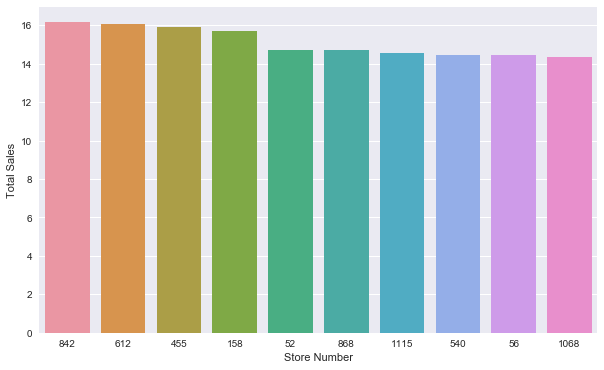

In [44]:
#Visualizing top 10 stores by avg_purchase_val
sn.set(rc={"figure.figsize": (10, 6)});

ax = sn.barplot( x = 'Store',
         y = 'avg_purchase_val' ,
         data = top_10_avg_purchse_val[0:10],
         order = top_10_avg_purchse_val.Store[0:10] )

ax.set( xlabel='Store Number',
     ylabel='Total Sales')
plt.show()

In [45]:
#Loading Stores Data
stores_df  = spark.read.csv('C:/Users/USER/Desktop/PySpark/Rossman Stores/store.csv',inferSchema=True,header=True)

In [46]:
stores_df.show( 5 )

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+
|    1|        c|         a|               1270|                        9|                    2008|     0|           null|           null|           null|
|    2|        a|         a|                570|                       11|                    2007|     1|             13|           2010|Jan,Apr,Jul,Oct|
|    3|        a|         a|              14130|                       12|                    2006|     1|             14|           2011|Jan,Apr,Jul,Oct|
|    4|        c|         c|                620|                      

In [47]:
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: integer (nullable = true)
 |-- CompetitionOpenSinceYear: integer (nullable = true)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



Again, from kaggle site, the column defintions are as follows:

- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [48]:
stores_df.columns

['Store',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

In [49]:
#How many different types of stores are there?
store_by_types = stores_df.groupBy( "StoreType" ).count()

In [50]:
store_by_types.show()

+---------+-----+
|StoreType|count|
+---------+-----+
|        d|  348|
|        c|  148|
|        b|   17|
|        a|  602|
+---------+-----+



In [52]:
#Different store types in percentages
total = stores_df.count()
total

1115

In [53]:
from pyspark.sql.functions import lit

In [54]:
store_by_types.withColumn( "percentage", round( col( "count" ) / lit( total ), 2) ).show()

+---------+-----+----------+
|StoreType|count|percentage|
+---------+-----+----------+
|        d|  348|      0.31|
|        c|  148|      0.13|
|        b|   17|      0.02|
|        a|  602|      0.54|
+---------+-----+----------+



In [55]:
#How long competitions exist for the stores?
#Write a function to calculate the total months passed since competition is opened?
stores_df = stores_df.withColumn(
  "CompetitionOpenSinceMonth",
  stores_df["CompetitionOpenSinceMonth"].cast( 'float' ) )

stores_df = stores_df.withColumn(
  "CompetitionOpenSinceYear",
  stores_df["CompetitionOpenSinceYear"].cast( 'float' ) )

In [56]:
stores_df = stores_df.fillna( 0.0 )

In [57]:
stores_df.where( col( "CompetitionOpenSinceYear" ).isNull() ).show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+



In [58]:
stores_df.where( col( "CompetitionOpenSinceMonth" ).isNull() ).show()

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+



In [59]:
from dateutil.relativedelta import relativedelta
from datetime import datetime
import math

def diff_in_months( fromYear, fromMonth ):
  if (fromYear == 0.0) or (fromMonth == 0.0):
      return 0.0
  else:
      return ( 2015.0 - fromYear ) * 12.0 + ( 12.0 - fromMonth )

In [60]:
diff_in_months( 2012, 3 )

45.0

In [61]:
from pyspark.sql.functions import udf, array

In [62]:
comp_months_udf = udf( diff_in_months, FloatType() )

In [63]:
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: float (nullable = false)
 |-- CompetitionOpenSinceYear: float (nullable = false)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)



In [80]:

stores_df = stores_df.withColumn( "comp_months",
                   comp_months_udf( stores_df.CompetitionOpenSinceYear,
                                stores_df.CompetitionOpenSinceMonth ) )

stores_df.cache()

DataFrame[Store: int, StoreType: string, Assortment: string, CompetitionDistance: int, CompetitionOpenSinceMonth: float, CompetitionOpenSinceYear: float, Promo2: int, Promo2SinceWeek: int, Promo2SinceYear: int, PromoInterval: string, comp_months: float]

In [81]:
stores_df.show(2)

+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+
|Store|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|comp_months|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+
|    1|        c|         a|               1270|                      9.0|                  2008.0|     0|              0|              0|           null|       87.0|
|    2|        a|         a|                570|                     11.0|                  2007.0|     1|             13|           2010|Jan,Apr,Jul,Oct|       97.0|
+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------

In [82]:
#Advanced OLAP functions
#Creating multi-dimensional cubes for sales on customers, month, year, promo, weekday dimensions

sales_cubes  = retail_df.cube( "year", "month", "DayOfWeek" ).avg("Sales")

In [83]:
sales_cubes = sales_cubes.sort( "year", "month", "DayOfWeek",
                             ascending = [False, False, False] )

In [84]:
sales_cubes.cache()

DataFrame[year: int, month: int, DayOfWeek: int, avg(Sales): double]

In [85]:
sales_cubes.show(65)

+----+-----+---------+------------------+
|year|month|DayOfWeek|        avg(Sales)|
+----+-----+---------+------------------+
|2015|    7|        7|253.49282511210762|
|2015|    7|        6| 5557.611210762332|
|2015|    7|        5| 7220.753542600897|
|2015|    7|        4|7039.3309417040355|
|2015|    7|        3| 7044.266188340807|
|2015|    7|        2| 6996.633183856502|
|2015|    7|        1| 8167.792152466368|
|2015|    7|     null| 6142.705511355417|
|2015|    6|        7| 234.2035874439462|
|2015|    6|        6|5811.1556053811655|
|2015|    6|        5| 7045.798878923767|
|2015|    6|        4| 5491.128699551569|
|2015|    6|        3| 6980.366367713004|
|2015|    6|        2| 7929.010582959641|
|2015|    6|        1| 8816.090762331838|
|2015|    6|     null| 6199.203976083707|
|2015|    5|        7| 232.5886995515695|
|2015|    5|        6| 6590.219910313901|
|2015|    5|        5|6143.7431390134525|
|2015|    5|        4| 5390.822197309417|
|2015|    5|        3| 7177.902242

In [86]:
custs_rollups = retail_df.rollup( "year", "month", "DayOfWeek" ).sum("Customers")

In [87]:
custs_rollups = custs_rollups.sort( "year", "month", "DayOfWeek",
                             ascending = [False, False, False] )

In [88]:
custs_rollups.cache()

DataFrame[year: int, month: int, DayOfWeek: int, sum(Customers): bigint]

In [89]:
custs_rollups.show(60)

+----+-----+---------+--------------+
|year|month|DayOfWeek|sum(Customers)|
+----+-----+---------+--------------+
|2015|    7|        7|        188144|
|2015|    7|        6|       2699949|
|2015|    7|        5|       4229917|
|2015|    7|        4|       4135350|
|2015|    7|        3|       4084639|
|2015|    7|        2|       3270527|
|2015|    7|        1|       3645362|
|2015|    7|     null|      22253888|
|2015|    6|        7|        177292|
|2015|    6|        6|       2817690|
|2015|    6|        5|       3381020|
|2015|    6|        4|       2737228|
|2015|    6|        3|       3325603|
|2015|    6|        2|       4438681|
|2015|    6|        1|       4767615|
|2015|    6|     null|      21645129|
|2015|    5|        7|        217516|
|2015|    5|        6|       3921955|
|2015|    5|        5|       3663158|
|2015|    5|        4|       2576555|
|2015|    5|        3|       3432759|
|2015|    5|        2|       3441435|
|2015|    5|        1|       2940470|
|2015|    5|

In [90]:
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: float (nullable = false)
 |-- CompetitionOpenSinceYear: float (nullable = false)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)
 |-- comp_months: float (nullable = true)



In [91]:
#Joining two dataframes
stores_limited_df = stores_df.select( 'Store',
                                    'StoreType',
                                    'Assortment',
                                    'CompetitionDistance',
                                    'comp_months')

stores_limited_df.show(10)

+-----+---------+----------+-------------------+-----------+
|Store|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+----------+-------------------+-----------+
|    1|        c|         a|               1270|       87.0|
|    2|        a|         a|                570|       97.0|
|    3|        a|         a|              14130|      108.0|
|    4|        c|         c|                620|       75.0|
|    5|        a|         a|              29910|        8.0|
|    6|        a|         a|                310|       24.0|
|    7|        a|         c|              24000|       32.0|
|    8|        a|         a|               7520|       14.0|
|    9|        a|         c|               2030|      184.0|
|   10|        a|         a|               3160|       75.0|
+-----+---------+----------+-------------------+-----------+
only showing top 10 rows



In [92]:
sales_by_stores_custs.show(10)

+-----+----------+--------------+----------------+
|Store|sum(Sales)|sum(Customers)|avg_purchase_val|
+-----+----------+--------------+----------------+
|  148|   6772949|        642470|           10.54|
|  463|   4747749|        755184|            6.29|
|  471|   4422266|        367107|           12.05|
|  496|   6059458|        650918|            9.31|
|  833|   4293342|        394316|           10.89|
| 1088|   3960984|        377930|           10.48|
|  243|   4407146|        594010|            7.42|
|  392|   5670675|        559386|           10.14|
|  540|   3513672|        243396|           14.44|
|  623|   5473895|        639137|            8.56|
+-----+----------+--------------+----------------+
only showing top 10 rows



In [93]:
all_stores_df = stores_limited_df.join( sales_by_stores_custs,
                                     on = ["Store"], how = 'inner' )

In [94]:
all_stores_df.show( 10 )

+-----+---------+----------+-------------------+-----------+----------+--------------+----------------+
|Store|StoreType|Assortment|CompetitionDistance|comp_months|sum(Sales)|sum(Customers)|avg_purchase_val|
+-----+---------+----------+-------------------+-----------+----------+--------------+----------------+
|  148|        a|         a|               2090|       84.0|   6772949|        642470|           10.54|
|  463|        a|         a|               4160|        0.0|   4747749|        755184|            6.29|
|  471|        d|         a|               5300|        0.0|   4422266|        367107|           12.05|
|  496|        d|         c|               2780|        6.0|   6059458|        650918|            9.31|
|  833|        d|         c|               3290|      192.0|   4293342|        394316|           10.89|
| 1088|        a|         a|               4300|       81.0|   3960984|        377930|           10.48|
|  243|        a|         a|                310|        0.0|   4

In [95]:
#Statistical Functions
all_stores_stats = all_stores_df.describe()

In [96]:
all_stores_stats.show()

+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|summary|            Store|StoreType|Assortment|CompetitionDistance|      comp_months|        sum(Sales)|   sum(Customers)|  avg_purchase_val|
+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|  count|             1115|     1115|      1115|               1115|             1115|              1115|             1115|              1115|
|   mean|            558.0|     null|      null|  5390.358744394619|55.11210762331839| 5267426.567713005|577615.9237668162| 9.643659192825114|
| stddev|322.0170802923348|     null|      null| 7657.9737053313265|71.94205843930182|1951304.4839653836|304654.5331405179|1.9869552301495716|
|    min|                1|        a|         a|                  0|              0.0|           2114322|           187583|              3.51|

In [97]:
#Convert the data types of the columns
all_stores_df = all_stores_df.withColumn(
  "CompetitionDistance",
  all_stores_df["CompetitionDistance"].cast( 'int' ) )

In [99]:

all_stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- comp_months: float (nullable = true)
 |-- sum(Sales): long (nullable = true)
 |-- sum(Customers): long (nullable = true)
 |-- avg_purchase_val: double (nullable = true)



In [122]:
all_stores_stats  = all_stores_df.describe()
all_stores_stats.show()

+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|summary|            Store|StoreType|Assortment|CompetitionDistance|      comp_months|        sum(Sales)|   sum(Customers)|  avg_purchase_val|
+-------+-----------------+---------+----------+-------------------+-----------------+------------------+-----------------+------------------+
|  count|             1115|     1115|      1115|               1115|             1115|              1115|             1115|              1115|
|   mean|            558.0|     null|      null|  5390.358744394619|55.11210762331839| 5267426.567713005|577615.9237668162| 9.643659192825114|
| stddev|322.0170802923348|     null|      null| 7657.9737053313265|71.94205843930182|1951304.4839653836|304654.5331405179|1.9869552301495716|
|    min|                1|        a|         a|                  0|              0.0|           2114322|           187583|              3.51|

Some data points missing in CompetitionDistance column. Only 1112 out of 1115 are available.

In [101]:
#Describe on a subset of columns
all_stores_df.describe( "CompetitionDistance", "avg_purchase_val" ).show()

+-------+-------------------+------------------+
|summary|CompetitionDistance|  avg_purchase_val|
+-------+-------------------+------------------+
|  count|               1115|              1115|
|   mean|  5390.358744394619| 9.643659192825114|
| stddev| 7657.9737053313265|1.9869552301495716|
|    min|                  0|              3.51|
|    max|              75860|             16.16|
+-------+-------------------+------------------+



In [102]:
#Finding correlation between variables
all_stores_df.stat.corr( 'CompetitionDistance', 'avg_purchase_val' )

0.23007011949360368

Surprisingly not very highly correlated. In fact, it is positively correlated, which sound unintuitive. This may be because the stores with low CompetitionDistance are located in crowded places. And Stores with high competition distance are placed in very low population areas. This explains why the sales are low, even when there is no competition.

In [103]:
all_stores_df.stat.corr( 'sum(Sales)', 'sum(Customers)' )

0.8542650646315252

This is expected to be highly correlated. Sales are higher when when there are higher footfalls.

In [104]:
#Running SQL Queries
#Registering sales data as a table
retail_df.registerTempTable( "retail" )

In [106]:
avg_sales_custs = spark.sql( """select Store, avg(Sales) as avg_sales,                 
                                 avg(Customers) as avg_custs from retail group by Store""" )
avg_sales_custs.cache()

DataFrame[Store: int, avg_sales: double, avg_custs: double]

In [107]:
avg_sales_custs.show(10)

+-----+------------------+------------------+
|Store|         avg_sales|         avg_custs|
+-----+------------------+------------------+
|  148| 7189.967091295117| 682.0276008492569|
|  463| 5040.073248407643| 801.6815286624204|
|  471|  5834.12401055409|484.31002638522426|
|  496| 6432.545647558386|  690.995753715499|
|  833|4557.6878980891715| 418.5944798301486|
| 1088| 4204.866242038216| 401.1995753715499|
|  243| 5814.176781002639| 783.6543535620053|
|  392| 6019.824840764331|  593.828025477707|
|  540| 4635.451187335092| 321.1029023746702|
|  623| 5810.928874734607| 678.4893842887474|
+-----+------------------+------------------+
only showing top 10 rows



In [108]:
#Creating Cubes and Rollups
spark.sql( "describe retail").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|        Store|      int|   null|
|    DayOfWeek|      int|   null|
|         Date|timestamp|   null|
|        Sales|      int|   null|
|    Customers|      int|   null|
|         Open|      int|   null|
|        Promo|      int|   null|
| StateHoliday|   string|   null|
|SchoolHoliday|      int|   null|
|        month|      int|   null|
|         year|      int|   null|
+-------------+---------+-------+



In [109]:
sales_rollups = spark.sql( '''select year, month, Store, sum(Sales) as total_sales
            from retail group by year, month, Store with rollup''')

In [110]:
sales_rollups.cache()

DataFrame[year: int, month: int, Store: int, total_sales: bigint]

In [111]:
sales_rollups.show(10)

+----+-----+-----+-----------+
|year|month|Store|total_sales|
+----+-----+-----+-----------+
|2015|    7|  126|     143960|
|2015|    7|  182|     151776|
|2015|    7|  362|     255891|
|2015|    7|  484|     214570|
|2015|    7|  487|     198074|
|2015|    7| 1061|     231236|
|2015|    6|    1|     110011|
|2015|    6|  161|     198112|
|2015|    6|  903|     294727|
|2015|    4|    4|     248088|
+----+-----+-----+-----------+
only showing top 10 rows



In [112]:
sales_rollups.dropna().registerTempTable( "sales_rollups" )

In [113]:
#Top 3 Stores for each month by sales revenue contribution
top3_query = """SELECT
  year,
  month,
  Store,
  total_sales,
  rank
FROM (
  SELECT
    Store,
    year,
    month,
    total_sales,
    rank() OVER (PARTITION BY year, month ORDER BY total_sales DESC) as rank
  FROM sales_rollups) tmp
WHERE
  rank <= 3 ORDER BY year, month, rank"""

In [115]:
top3_store_by_month = spark.sql( top3_query )
top3_store_by_month.cache()

DataFrame[year: int, month: int, Store: int, total_sales: bigint, rank: int]

In [116]:
top3_store_by_month.show( 30 )

+----+-----+-----+-----------+----+
|year|month|Store|total_sales|rank|
+----+-----+-----+-----------+----+
|2013|    1|  817|     616461|   1|
|2013|    1|  262|     566482|   2|
|2013|    1|  562|     527869|   3|
|2013|    2|  817|     561454|   1|
|2013|    2|  262|     549174|   2|
|2013|    2|  562|     488061|   3|
|2013|    3|  262|     673085|   1|
|2013|    3|  817|     615420|   2|
|2013|    3|  562|     572658|   3|
|2013|    4|  262|     610222|   1|
|2013|    4|  817|     606697|   2|
|2013|    4|  562|     528838|   3|
|2013|    5|  262|     711428|   1|
|2013|    5|  817|     617836|   2|
|2013|    5|  562|     564743|   3|
|2013|    6|  262|     630094|   1|
|2013|    6|  817|     609556|   2|
|2013|    6|  562|     541954|   3|
|2013|    7|  262|     615851|   1|
|2013|    7|  817|     609614|   2|
|2013|    7| 1114|     548603|   3|
|2013|    8|  262|     628556|   1|
|2013|    8|  817|     587789|   2|
|2013|    8| 1114|     559259|   3|
|2013|    9|  262|     60055

In [117]:
#Writing dataframes using Parquet Format
retail_df.write.parquet( "retail.parquet" )

In [118]:
stores_limited_df.show( 5 )

+-----+---------+----------+-------------------+-----------+
|Store|StoreType|Assortment|CompetitionDistance|comp_months|
+-----+---------+----------+-------------------+-----------+
|    1|        c|         a|               1270|       87.0|
|    2|        a|         a|                570|       97.0|
|    3|        a|         a|              14130|      108.0|
|    4|        c|         c|                620|       75.0|
|    5|        a|         a|              29910|        8.0|
+-----+---------+----------+-------------------+-----------+
only showing top 5 rows



In [119]:
stores_limited_df.write.parquet( "stores_limited.parquet" )

# Model Building

### Model Building with out feature engineering

In [120]:
stores_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- StoreType: string (nullable = true)
 |-- Assortment: string (nullable = true)
 |-- CompetitionDistance: integer (nullable = true)
 |-- CompetitionOpenSinceMonth: float (nullable = false)
 |-- CompetitionOpenSinceYear: float (nullable = false)
 |-- Promo2: integer (nullable = true)
 |-- Promo2SinceWeek: integer (nullable = true)
 |-- Promo2SinceYear: integer (nullable = true)
 |-- PromoInterval: string (nullable = true)
 |-- comp_months: float (nullable = true)



In [121]:
retail_df.printSchema()

root
 |-- Store: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Sales: integer (nullable = true)
 |-- Customers: integer (nullable = true)
 |-- Open: integer (nullable = true)
 |-- Promo: integer (nullable = true)
 |-- StateHoliday: string (nullable = true)
 |-- SchoolHoliday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)



#### Selecting columns to predict store sales
To predict sales of stores we can use the following features to make prediction. Customers, Open and Date columns will not be used. Customers column data will not be availble while making predictions and Date may create overfitting problems. Open will be always 1 for the day for which we will make predictions in future. For Open = 0, we know the sales will be 0, as the store is closed.

In [123]:
store_sales_df = retail_df.select('Store',
'DayOfWeek',
'Promo',
'StateHoliday',
'SchoolHoliday',
'month',
'year',
'Sales',
)

We can add more featurs about the stores from stores dataframe. For example, store type, assortment type, competition distances and how long the competitions have been there etc.

In [124]:
#Join store sales and stores dataframe 
#Adding store variables to the sales data.
store_sales_df = store_sales_df.join( stores_df, on = "Store", how = "inner" )

In [125]:
store_sales_df.cache()

DataFrame[Store: int, DayOfWeek: int, Promo: int, StateHoliday: string, SchoolHoliday: int, month: int, year: int, Sales: int, StoreType: string, Assortment: string, CompetitionDistance: int, CompetitionOpenSinceMonth: float, CompetitionOpenSinceYear: float, Promo2: int, Promo2SinceWeek: int, Promo2SinceYear: int, PromoInterval: string, comp_months: float]

In [126]:
store_sales_df.show(5)

+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|comp_months|
+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+
|    1|        5|    1|           0|            1|    7|2015| 5263|        c|         a|               1270|                      9.0|                  2008.0|     0|              0|              0|           null|       87.0|
|    2|        5|    1|           0|            1|    7|2015| 6064|        a|         a|    

In [128]:
store_sales_df.columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'Sales',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'comp_months']

Remove rows with 0 observations
- There are days with zero sales. These are the days when the stores are closed. So, we need not take these data for model building. So, we can remove all entries with zero observations.

In [129]:
store_sales_df  = store_sales_df.where( store_sales_df.Sales > 0 )

In [130]:
# Fill all null values with zero.
store_sales_df.fillna( 0 )

DataFrame[Store: int, DayOfWeek: int, Promo: int, StateHoliday: string, SchoolHoliday: int, month: int, year: int, Sales: int, StoreType: string, Assortment: string, CompetitionDistance: int, CompetitionOpenSinceMonth: float, CompetitionOpenSinceYear: float, Promo2: int, Promo2SinceWeek: int, Promo2SinceYear: int, PromoInterval: string, comp_months: float]

In [131]:
store_sales_df = store_sales_df.na.drop( how = 'any' )

In [132]:
#Which are categorical and which are continuous features?
cat_features = ['DayOfWeek',
              'Promo',
              'StateHoliday',
              'SchoolHoliday',
              'month',
              'year',
              'StoreType',
              'Assortment']

In [133]:
continuous_features = ['CompetitionDistance', 'comp_months']

In [134]:
#Function to encode categorical features
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, PolynomialExpansion, VectorIndexer

In [135]:
def create_category_vars( dataset, field_name ):
    idx_col = field_name + "Index"
    col_vec = field_name + "Vec"

    month_stringIndexer = StringIndexer( inputCol=field_name, outputCol=idx_col )

    month_model = month_stringIndexer.fit( dataset )
    month_indexed = month_model.transform( dataset )

    month_encoder = OneHotEncoder( dropLast=True,inputCol=idx_col,outputCol= col_vec )

    return month_encoder.transform( month_indexed )

In [137]:
for  col in  cat_features:
    store_sales_df = create_category_vars( store_sales_df, col )
    store_sales_df.cache()

In [138]:
store_sales_df.columns

['Store',
 'DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'Sales',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'comp_months',
 'DayOfWeekIndex',
 'DayOfWeekVec',
 'PromoIndex',
 'PromoVec',
 'StateHolidayIndex',
 'StateHolidayVec',
 'SchoolHolidayIndex',
 'SchoolHolidayVec',
 'monthIndex',
 'monthVec',
 'yearIndex',
 'yearVec',
 'StoreTypeIndex',
 'StoreTypeVec',
 'AssortmentIndex',
 'AssortmentVec']

In [139]:
store_sales_df.show(5)

+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+---------------+-----------+--------------+-------------+----------+---------+-----------------+---------------+------------------+----------------+----------+--------------+---------+---------+--------------+-------------+---------------+-------------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|  PromoInterval|comp_months|DayOfWeekIndex| DayOfWeekVec|PromoIndex| PromoVec|StateHolidayIndex|StateHolidayVec|SchoolHolidayIndex|SchoolHolidayVec|monthIndex|      monthVec|yearIndex|  yearVec|StoreTypeIndex| StoreTypeVec|AssortmentIndex|AssortmentVec|
+-----+---------+-----+------------+-------------+-----+----+-----+---------+----------+--------

In [140]:
categorical_vecs = [ "".join( (cat, "Vec") ) for cat in cat_features ]

In [141]:
categorical_vecs

['DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec']

In [144]:
#Including all features for model building

all_features= continuous_features + categorical_vecs

In [145]:
all_features

['CompetitionDistance',
 'comp_months',
 'DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec']

In [146]:
# Creating the vector of all predictors
assembler = VectorAssembler( inputCols = all_features, outputCol = "features")

In [147]:
store_sales_df = assembler.transform( store_sales_df )

In [148]:
# Setting the target variables - Sales
store_sales_df = store_sales_df.withColumn( "label", store_sales_df.Sales.cast( 'double' ) )

In [149]:
store_sales_df.select( "features", "label" ).show( 5 )

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|(31,[0,1,5,9,16,2...| 6064.0|
|(31,[0,1,5,9,16,2...| 8314.0|
|(31,[0,1,5,9,16,2...|10457.0|
|(31,[0,5,9,16,26,...| 8959.0|
|(31,[0,5,9,12,16,...| 8821.0|
+--------------------+-------+
only showing top 5 rows



In [156]:
#Split the dataset
train_df, test_df = store_sales_df.randomSplit( [0.7, 0.3], seed = 42 )

In [157]:
#Train Linear Regression Model
from pyspark.ml.regression import LinearRegression

In [158]:
linreg = LinearRegression(maxIter=500, regParam=0.0)
lm = linreg.fit( train_df )

In [159]:
# Intercept and coefficients
lm.intercept

7692.316948142101

In [160]:
lm.coefficients

DenseVector([0.0148, 0.7732, 1000.6235, 704.9467, 398.2732, 833.3832, 1749.2102, 450.7182, -2343.2226, 1747.3774, 1042.577, 314.6419, -336.2019, -1991.4841, -1722.6806, -1593.8426, -1824.9593, -1642.6397, -1963.119, -1547.1543, -2058.465, -1908.5632, -1962.0968, -1451.1997, -372.7271, -168.5543, -7353.8661, -7574.7103, -7844.6654, 6817.4094, 7409.7812])

In [162]:
#Making predictions on test data
y_pred  =  lm.transform( test_df )
y_pred.select( 'features', 'label', 'prediction' ).show( 5 )

+--------------------+------+-----------------+
|            features| label|       prediction|
+--------------------+------+-----------------+
|(31,[0,1,6,8,9,12...|3633.0|6093.341118471883|
|(31,[0,1,6,8,9,12...|3678.0|6093.341118471883|
|(31,[0,1,6,8,9,12...|3967.0|6333.779576289096|
|(31,[0,1,6,8,9,25...|5999.0| 8224.10771370342|
|(31,[0,1,6,9,12,1...|7237.0|8408.198688860612|
+--------------------+------+-----------------+
only showing top 5 rows



In [163]:
# Metrics to check the accuracy of model (goodness of fit)
#Calculating RMSE and R-Squared
from pyspark.ml.evaluation import RegressionEvaluator

In [164]:
rmse_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="rmse" )

In [165]:
lm_rmse = rmse_evaluator.evaluate( y_pred )
lm_rmse

2344.1233418155234

In [166]:
r2_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="r2" )
lm_r2 = r2_evaluator.evaluate( y_pred )
lm_r2

0.2640729555935112

Accuracy of the model is very poor. This may be because we do not have right or enough variables which can predict the sales better. We can do feature engineering to create more features.

### Model building after feature engineering

#### Feature Engineering
- The sales might be influenced by if the next day is a holiday.
- What is the sales for the last 2 and 5 days?

In [168]:
#Is the next day a state holiday?
retail_df.show(5)

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+
|    1|        5|2015-07-31 00:00:00| 5263|      555|   1|    1|           0|            1|    7|2015|
|    2|        5|2015-07-31 00:00:00| 6064|      625|   1|    1|           0|            1|    7|2015|
|    3|        5|2015-07-31 00:00:00| 8314|      821|   1|    1|           0|            1|    7|2015|
|    4|        5|2015-07-31 00:00:00|13995|     1498|   1|    1|           0|            1|    7|2015|
|    5|        5|2015-07-31 00:00:00| 4822|      559|   1|    1|           0|            1|    7|2015|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+
only showing top 5 rows



In [169]:
from pyspark.sql.functions import lag, col, lead
from pyspark.sql.window import Window

w = Window().partitionBy("Store").orderBy(col("Date"))
retail_new_df = retail_df.select("*", lead("StateHoliday").over(w).alias("next_day_state_holiday"))
retail_new_df.cache()
retail_new_df.show(5)

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+
|  148|        2|2013-01-01 00:00:00|    0|        0|   0|    0|           a|            1|    1|2013|                     0|
|  148|        3|2013-01-02 00:00:00| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|
|  148|        4|2013-01-03 00:00:00| 7517|      753|   1|    0|           0|            1|    1|2013|                     0|
|  148|        5|2013-01-04 00:00:00| 7482|      721|   1|    0|           0|            1|    1|2013|                     0|
|  148|        6|2013-01-05 00:00:00| 7750|      756|   1|    0|           0|            0|    1|2013|                

In [170]:
# Is the next day a school holiday?
w = Window().partitionBy("Store").orderBy(col("Date"))
retail_new_df = retail_new_df.select("*", lead("SchoolHoliday").over(w).alias("next_day_school_holiday"))
retail_new_df.cache()
retail_new_df.show(5)

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|next_day_school_holiday|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+
|  148|        2|2013-01-01 00:00:00|    0|        0|   0|    0|           a|            1|    1|2013|                     0|                      1|
|  148|        3|2013-01-02 00:00:00| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|                      1|
|  148|        4|2013-01-03 00:00:00| 7517|      753|   1|    0|           0|            1|    1|2013|                     0|                      1|
|  148|        5|2013-01-04 00:00:00| 7482|      721|   1|    0|           0|            1|    1|201

In [172]:
# mean sales for the last 2 days

w  =  Window().partitionBy("Store").orderBy("Date")

retail_new_df = retail_new_df.withColumn("avg_sales_last_2days",
                                       ( lag("Sales", 1).over(w) + lag("Sales", 2).over(w) ) / 2 )

In [173]:
retail_new_df.show(5)

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+
|  148|        2|2013-01-01 00:00:00|    0|        0|   0|    0|           a|            1|    1|2013|                     0|                      1|                null|
|  148|        3|2013-01-02 00:00:00| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|                      1|                null|
|  148|        4|2013-01-03 00:00:00| 7517|      753|   1|    0|           0|            1|    1|2013|                     0|                    

In [174]:
w = Window().partitionBy("Store").orderBy("Date")

retail_new_df = retail_new_df.withColumn("avg_sales_last_5days",
                                       ( lag("Sales", 1).over(w)
                                        + lag("Sales", 2).over(w)
                                        + lag("Sales", 3).over(w)
                                        + lag("Sales", 4).over(w)
                                        + lag("Sales", 5).over(w) ) / 5 )

In [175]:
retail_new_df.show( 10 )

+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+--------------------+
|Store|DayOfWeek|               Date|Sales|Customers|Open|Promo|StateHoliday|SchoolHoliday|month|year|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|
+-----+---------+-------------------+-----+---------+----+-----+------------+-------------+-----+----+----------------------+-----------------------+--------------------+--------------------+
|  148|        2|2013-01-01 00:00:00|    0|        0|   0|    0|           a|            1|    1|2013|                     0|                      1|                null|                null|
|  148|        3|2013-01-02 00:00:00| 7944|      781|   1|    0|           0|            1|    1|2013|                     0|                      1|                null|                null|
|  148|        4|2013-01-03 00:00:00| 75

In [176]:
# Average sales per store for each month
avg_sales_store_by_month = retail_new_df.groupBy( "Store", "month" ).avg( "Sales" )

In [177]:
avg_sales_store_by_month.show( 5 )

+-----+-----+------------------+
|Store|month|        avg(Sales)|
+-----+-----+------------------+
|  148|    1| 6933.451612903225|
|  148|    2|7115.5952380952385|
|  148|    3| 7271.602150537635|
|  148|    4| 7273.922222222222|
|  148|    5| 6978.043010752688|
+-----+-----+------------------+
only showing top 5 rows



In [178]:
retail_new_df = retail_new_df.join( avg_sales_store_by_month, on = ["Store", "month"], how = "inner" )

In [179]:
from pyspark.sql.functions import round

In [182]:
retail_new_df = retail_new_df.withColumn( "avg_sales_by_month",
                                       round( retail_new_df["avg(Sales)"], 2 ) )

In [183]:
store_sales_new_df = store_sales_df = retail_new_df.select('Store',
                                                   'DayOfWeek',
                                                   'Promo',
                                                   'StateHoliday',
                                                   'SchoolHoliday',
                                                   'month',
                                                   'year',
                                                   'Sales',
                                                   'next_day_state_holiday',
                                                   'next_day_school_holiday',
                                                   'avg_sales_last_2days',
                                                   'avg_sales_last_5days',
                                                   'avg_sales_by_month'
                                                  )

In [184]:
store_sales_new_df = store_sales_new_df.join( stores_df, on = "Store", how = "inner" )

In [185]:
store_sales_new_df.cache()
store_sales_new_df.show(5)

+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+-----------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|avg_sales_by_month|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|comp_months|
+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+-----------+
|

In [186]:
#Considering the new features
cat_features_new = cat_features + ['next_day_state_holiday', 'next_day_school_holiday']
cat_features_new

['DayOfWeek',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'month',
 'year',
 'StoreType',
 'Assortment',
 'next_day_state_holiday',
 'next_day_school_holiday']

In [187]:
continuous_features_new = continuous_features + ['avg_sales_last_2days', 'avg_sales_last_5days', 'avg_sales_by_month']
continuous_features_new

['CompetitionDistance',
 'comp_months',
 'avg_sales_last_2days',
 'avg_sales_last_5days',
 'avg_sales_by_month']

In [188]:
#Encoding the categorical features
store_sales_new_df.show(5)

+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+-----------+
|Store|DayOfWeek|Promo|StateHoliday|SchoolHoliday|month|year|Sales|next_day_state_holiday|next_day_school_holiday|avg_sales_last_2days|avg_sales_last_5days|avg_sales_by_month|StoreType|Assortment|CompetitionDistance|CompetitionOpenSinceMonth|CompetitionOpenSinceYear|Promo2|Promo2SinceWeek|Promo2SinceYear|PromoInterval|comp_months|
+-----+---------+-----+------------+-------------+-----+----+-----+----------------------+-----------------------+--------------------+--------------------+------------------+---------+----------+-------------------+-------------------------+------------------------+------+---------------+---------------+-------------+-----------+
|

In [189]:
# Dropping all observations will null values
store_sales_new_df = store_sales_new_df.na.drop( how = 'any' )

In [190]:
for col in cat_features_new:
    store_sales_new_df = create_category_vars( store_sales_new_df, col )
    store_sales_new_df.cache()

In [191]:
categorical_vecs_new = [ "".join( (cat, "Vec") ) for cat in cat_features_new ]

In [192]:
categorical_vecs_new

['DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec',
 'next_day_state_holidayVec',
 'next_day_school_holidayVec']

In [193]:
all_features_new = continuous_features_new + categorical_vecs_new
all_features_new

['CompetitionDistance',
 'comp_months',
 'avg_sales_last_2days',
 'avg_sales_last_5days',
 'avg_sales_by_month',
 'DayOfWeekVec',
 'PromoVec',
 'StateHolidayVec',
 'SchoolHolidayVec',
 'monthVec',
 'yearVec',
 'StoreTypeVec',
 'AssortmentVec',
 'next_day_state_holidayVec',
 'next_day_school_holidayVec']

In [194]:
#Creating vector of all features and target variable
assembler = VectorAssembler( inputCols = all_features_new, outputCol = "features")
store_sales_new_df = assembler.transform( store_sales_new_df )
store_sales_new_df = store_sales_new_df.withColumn( "label", store_sales_new_df.Sales.cast( 'double' ) )
store_sales_new_df.select( "features", "label" ).show( 5 )

+--------------------+------+
|            features| label|
+--------------------+------+
|(38,[0,2,3,4,7,11...|   0.0|
|(38,[0,2,3,4,6,12...|9568.0|
|(38,[0,2,3,4,8,12...|8215.0|
|(38,[0,2,3,4,9,12...|7291.0|
|(38,[0,2,3,4,5,12...|7294.0|
+--------------------+------+
only showing top 5 rows



In [195]:
#Splitting dataset
seed = 42

train_df, test_df = store_sales_new_df.randomSplit( [0.7, 0.3], seed = seed )

In [197]:
# Building the model
linreg = LinearRegression(maxIter=500, regParam=0.0) 
lm = linreg.fit( train_df )

In [198]:
#Model intercept and coefficients
lm.intercept

-4460.333481235426

In [199]:
lm.coefficients

DenseVector([0.0001, 0.0042, 0.1018, -0.1356, 1.0324, -722.5312, 934.4626, -5609.3283, -167.3494, -814.0988, -289.7708, -2185.3928, 5764.6377, -340.6799, -1465.0111, -201.5787, 374.1541, -95.7133, 22.4533, 81.7169, 35.3683, -92.0791, -397.2274, 470.7493, -159.5488, 64.9963, 55.195, -309.2197, -149.8962, -37.2718, -31.1228, -34.6414, 33.7698, 22.9525, 1590.9295, 2341.4141, 2618.9053, -89.0204])

In [200]:
#Predicting on test dataset
y_pred = lm.transform( test_df )
y_pred.select( 'features', 'label', 'prediction' ).show( 5 )

+--------------------+------+-----------------+
|            features| label|       prediction|
+--------------------+------+-----------------+
|(38,[0,2,3,4,6,11...|5940.0|6585.964268811464|
|(38,[0,2,3,4,6,11...|5440.0|6741.238537988245|
|(38,[0,2,3,4,6,11...|5897.0|6714.655856234724|
|(38,[0,2,3,4,6,11...|5492.0|6757.185621947325|
|(38,[0,2,3,4,6,11...|5752.0|6860.965198139051|
+--------------------+------+-----------------+
only showing top 5 rows



In [201]:
#Calculating model accuracy: RMSE and R-Squared
r2_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="r2" )

lm_r2 = r2_evaluator.evaluate( y_pred )
lm_r2

0.8170474412393387

In [202]:
rmse_evaluator = RegressionEvaluator(labelCol="label",
                            predictionCol="prediction",
                            metricName="rmse" )

lm_rmse = rmse_evaluator.evaluate( y_pred )
lm_rmse

1502.8101426255262

The new model has good prediction accuracy. The new variables seem to have increased accuracy of the model.